In [2]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
!pip install mlflow

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiement")

<Experiment: artifact_location='/workspaces/MLOps_zoomcamp/02-Experiment-tracking/mlruns/1', creation_time=1716314940833, experiment_id='1', last_update_time=1716314940833, lifecycle_stage='active', name='nyc-taxi-experiement', tags={}>

In [5]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.060351538806409

/tmp/ipykernel_7883/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_7883/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level fun

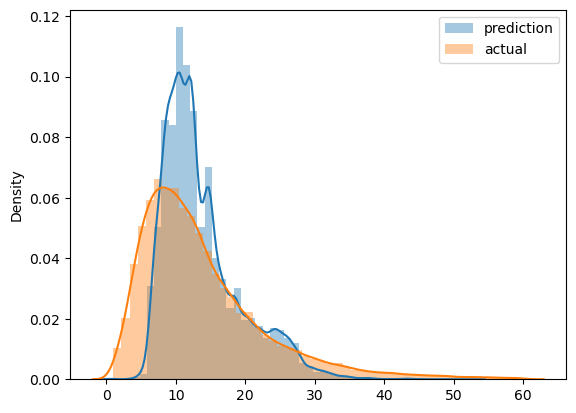

In [7]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')
len(df_train), len(df_val)

(65946, 62574)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.034386403820207

In [12]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [13]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha=0.001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [14]:
!pip install xgboost hyperopt

In [15]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [17]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [18]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:07:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99601                           
[1]	validation-rmse:8.69391                           
[2]	validation-rmse:8.41267                           
[3]	validation-rmse:8.15268                           
[4]	validation-rmse:7.91167                           
[5]	validation-rmse:7.68884                           
[6]	validation-rmse:7.48325                           
[7]	validation-rmse:7.29344                           
[8]	validation-rmse:7.11867                           
[9]	validation-rmse:6.95776                           
[10]	validation-rmse:6.81008                          
[11]	validation-rmse:6.67362                          
[12]	validation-rmse:6.54985                          
[13]	validation-rmse:6.43596                          
[14]	validation-rmse:6.33087                          
[15]	validation-rmse:6.23574                          
[16]	validation-rmse:6.14831                          
[17]	validation-rmse:6.06809                          
[18]	valid

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:08:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.74707                                                    
[1]	validation-rmse:5.47648                                                    
[2]	validation-rmse:5.42024                                                    
[3]	validation-rmse:5.38916                                                    
[4]	validation-rmse:5.37674                                                    
[5]	validation-rmse:5.36727                                                    
[6]	validation-rmse:5.36558                                                    
[7]	validation-rmse:5.35883                                                    
[8]	validation-rmse:5.35533                                                    
[9]	validation-rmse:5.35305                                                    
[10]	validation-rmse:5.34975                                                   
[11]	validation-rmse:5.34474                                                   
[12]	validation-rmse:5.33088            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:08:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.68633                                                    
[3]	validation-rmse:6.28251                                                    
[4]	validation-rmse:6.00989                                                    
[5]	validation-rmse:5.82556                                                    
[6]	validation-rmse:5.70306                                                    
[7]	validation-rmse:5.62013                                                    
[8]	validation-rmse:5.56661                                                    
[9]	validation-rmse:5.52376                                                    
[10]	validation-rmse:5.49404                                                   
[11]	validation-rmse:5.47550                                                   
[12]	validation-rmse:5.46000                                                   
[13]	validation-rmse:5.45267                                                   
[14]	validation-rmse:5.44709            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:08:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.77271                                                    
[1]	validation-rmse:5.83609                                                    
[2]	validation-rmse:5.51601                                                    
[3]	validation-rmse:5.41042                                                    
[4]	validation-rmse:5.36415                                                    
[5]	validation-rmse:5.34608                                                    
[6]	validation-rmse:5.33650                                                    
[7]	validation-rmse:5.33073                                                    
[8]	validation-rmse:5.32652                                                    
[9]	validation-rmse:5.32549                                                    
[10]	validation-rmse:5.32380                                                   
[11]	validation-rmse:5.31576                                                   
[12]	validation-rmse:5.31425            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:09:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.92281                                                    
[1]	validation-rmse:6.97916                                                    
[2]	validation-rmse:6.36530                                                    
[3]	validation-rmse:5.97218                                                    
[4]	validation-rmse:5.71860                                                    
[5]	validation-rmse:5.55846                                                    
[6]	validation-rmse:5.46108                                                    
[7]	validation-rmse:5.39285                                                    
[8]	validation-rmse:5.34946                                                    
[9]	validation-rmse:5.31836                                                    
[10]	validation-rmse:5.29693                                                   
[11]	validation-rmse:5.28677                                                   
[12]	validation-rmse:5.27019            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:09:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.93377                                                    
[1]	validation-rmse:5.37088                                                    
[2]	validation-rmse:5.27462                                                    
[3]	validation-rmse:5.24002                                                    
[4]	validation-rmse:5.22822                                                    
[5]	validation-rmse:5.22269                                                    
[6]	validation-rmse:5.21921                                                    
[7]	validation-rmse:5.21407                                                    
[8]	validation-rmse:5.21148                                                    
[9]	validation-rmse:5.20807                                                    
[10]	validation-rmse:5.20408                                                   
[11]	validation-rmse:5.19848                                                   
[12]	validation-rmse:5.19500            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:09:36] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86485                                                    
[1]	validation-rmse:8.45539                                                    
[2]	validation-rmse:8.08962                                                    
[3]	validation-rmse:7.76386                                                    
[4]	validation-rmse:7.47465                                                    
[5]	validation-rmse:7.21845                                                    
[6]	validation-rmse:6.99200                                                    
[7]	validation-rmse:6.79262                                                    
[8]	validation-rmse:6.61726                                                    
[9]	validation-rmse:6.46369                                                    
[10]	validation-rmse:6.32917                                                   
[11]	validation-rmse:6.21158                                                   
[12]	validation-rmse:6.10913            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:10:38] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.23062                                                    
[1]	validation-rmse:7.41766                                                    
[2]	validation-rmse:6.82165                                                    
[3]	validation-rmse:6.39250                                                    
[4]	validation-rmse:6.08827                                                    
[5]	validation-rmse:5.87524                                                    
[6]	validation-rmse:5.72534                                                    
[7]	validation-rmse:5.61758                                                    
[8]	validation-rmse:5.54490                                                    
[9]	validation-rmse:5.49310                                                    
[10]	validation-rmse:5.45717                                                   
[11]	validation-rmse:5.42772                                                   
[12]	validation-rmse:5.40278            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.47345                                                    
[1]	validation-rmse:6.40790                                                    
[2]	validation-rmse:5.82531                                                    
[3]	validation-rmse:5.52363                                                    
[4]	validation-rmse:5.36144                                                    
[5]	validation-rmse:5.27948                                                    
[6]	validation-rmse:5.23368                                                    
[7]	validation-rmse:5.20583                                                    
[8]	validation-rmse:5.18900                                                    
[9]	validation-rmse:5.17629                                                    
[10]	validation-rmse:5.16908                                                   
[11]	validation-rmse:5.16576                                                   
[12]	validation-rmse:5.16308            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:11:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:8.01376                                                    
[4]	validation-rmse:7.75555                                                    
[5]	validation-rmse:7.52081                                                    
[6]	validation-rmse:7.30941                                                    
[7]	validation-rmse:7.11607                                                    
[8]	validation-rmse:6.94181                                                    
[9]	validation-rmse:6.78469                                                    
[10]	validation-rmse:6.64255                                                   
[11]	validation-rmse:6.51498                                                   
[12]	validation-rmse:6.39980                                                   
[13]	validation-rmse:6.29717                                                   
[14]	validation-rmse:6.20545                                                   
[15]	validation-rmse:6.12259            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:12:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.90809                                                     
[3]	validation-rmse:6.48238                                                     
[4]	validation-rmse:6.17766                                                     
[5]	validation-rmse:5.96022                                                     
[6]	validation-rmse:5.80426                                                     
[7]	validation-rmse:5.69377                                                     
[8]	validation-rmse:5.61264                                                     
[9]	validation-rmse:5.55386                                                     
[10]	validation-rmse:5.51086                                                    
[11]	validation-rmse:5.47877                                                    
[12]	validation-rmse:5.45468                                                    
[13]	validation-rmse:5.43545                                                    
[14]	validation-rmse:5.42224

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:12:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.49458                                                     
[1]	validation-rmse:6.45812                                                     
[2]	validation-rmse:5.89964                                                     
[3]	validation-rmse:5.60425                                                     
[4]	validation-rmse:5.45330                                                     
[5]	validation-rmse:5.37190                                                     
[6]	validation-rmse:5.32345                                                     
[7]	validation-rmse:5.28925                                                     
[8]	validation-rmse:5.26797                                                     
[9]	validation-rmse:5.25332                                                     
[10]	validation-rmse:5.24619                                                    
[11]	validation-rmse:5.24165                                                    
[12]	validation-rmse:5.23344

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:13:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54252                                                     
[1]	validation-rmse:7.90020                                                     
[2]	validation-rmse:7.37575                                                     
[3]	validation-rmse:6.94971                                                     
[4]	validation-rmse:6.60793                                                     
[5]	validation-rmse:6.34036                                                     
[6]	validation-rmse:6.12681                                                     
[7]	validation-rmse:5.95722                                                     
[8]	validation-rmse:5.81706                                                     
[9]	validation-rmse:5.71406                                                     
[10]	validation-rmse:5.62770                                                    
[11]	validation-rmse:5.56481                                                    
[12]	validation-rmse:5.51196

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:13:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.32984                                                     
[1]	validation-rmse:6.28357                                                     
[2]	validation-rmse:5.78527                                                     
[3]	validation-rmse:5.54276                                                     
[4]	validation-rmse:5.41161                                                     
[5]	validation-rmse:5.35364                                                     
[6]	validation-rmse:5.32245                                                     
[7]	validation-rmse:5.30545                                                     
[8]	validation-rmse:5.29730                                                     
[9]	validation-rmse:5.29250                                                     
[10]	validation-rmse:5.28970                                                    
[11]	validation-rmse:5.28613                                                    
[12]	validation-rmse:5.28499

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:13:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.28679                                                     
[5]	validation-rmse:6.05720                                                     
[6]	validation-rmse:5.89136                                                     
[7]	validation-rmse:5.76976                                                     
[8]	validation-rmse:5.67767                                                     
[9]	validation-rmse:5.61309                                                     
[10]	validation-rmse:5.56323                                                    
[11]	validation-rmse:5.52654                                                    
[12]	validation-rmse:5.49878                                                    
[13]	validation-rmse:5.47511                                                    
[14]	validation-rmse:5.45922                                                    
[15]	validation-rmse:5.44413                                                    
[16]	validation-rmse:5.43238

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:14:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.24952                                                     
[1]	validation-rmse:6.16884                                                     
[2]	validation-rmse:5.65486                                                     
[3]	validation-rmse:5.41138                                                     
[4]	validation-rmse:5.30032                                                     
[5]	validation-rmse:5.24339                                                     
[6]	validation-rmse:5.21353                                                     
[7]	validation-rmse:5.19745                                                     
[8]	validation-rmse:5.18684                                                     
[9]	validation-rmse:5.18013                                                     
[10]	validation-rmse:5.17692                                                    
[11]	validation-rmse:5.17512                                                    
[12]	validation-rmse:5.17490

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:14:42] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.51006                                                     
[1]	validation-rmse:5.38643                                                     
[2]	validation-rmse:5.35368                                                     
[3]	validation-rmse:5.33319                                                     
[4]	validation-rmse:5.32856                                                     
[5]	validation-rmse:5.32092                                                     
[6]	validation-rmse:5.31639                                                     
[7]	validation-rmse:5.30991                                                     
[8]	validation-rmse:5.30710                                                     
[9]	validation-rmse:5.30344                                                     
[10]	validation-rmse:5.30054                                                    
[11]	validation-rmse:5.30032                                                    
[12]	validation-rmse:5.28994

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:14:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.70472                                                     
[2]	validation-rmse:8.42974                                                     
[3]	validation-rmse:8.17543                                                     
[4]	validation-rmse:7.94051                                                     
[5]	validation-rmse:7.72391                                                     
[6]	validation-rmse:7.52440                                                     
[7]	validation-rmse:7.34097                                                     
[8]	validation-rmse:7.17252                                                     
[9]	validation-rmse:7.01785                                                     
[10]	validation-rmse:6.87624                                                    
[11]	validation-rmse:6.74676                                                    
[12]	validation-rmse:6.62835                                                    
[13]	validation-rmse:6.51974

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:16:52] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.91626                                                     
[1]	validation-rmse:8.54744                                                     
[2]	validation-rmse:8.21215                                                     
[3]	validation-rmse:7.90663                                                     
[4]	validation-rmse:7.63106                                                     
[5]	validation-rmse:7.38036                                                     
[6]	validation-rmse:7.15531                                                     
[7]	validation-rmse:6.95169                                                     
[8]	validation-rmse:6.76877                                                     
[9]	validation-rmse:6.60303                                                     
[10]	validation-rmse:6.45558                                                    
[11]	validation-rmse:6.32357                                                    
[12]	validation-rmse:6.20544

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:17:58] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.55849                                                     
[2]	validation-rmse:8.22939                                                     
[3]	validation-rmse:7.92983                                                     
[4]	validation-rmse:7.66016                                                     
[5]	validation-rmse:7.41754                                                     
[6]	validation-rmse:7.19784                                                     
[7]	validation-rmse:7.00038                                                     
[8]	validation-rmse:6.82214                                                     
[9]	validation-rmse:6.66622                                                     
[10]	validation-rmse:6.52365                                                    
[11]	validation-rmse:6.39665                                                    
[12]	validation-rmse:6.28533                                                    
[13]	validation-rmse:6.18429

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:18:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62967                                                     
[1]	validation-rmse:8.04165                                                     
[2]	validation-rmse:7.54638                                                     
[3]	validation-rmse:7.12901                                                     
[4]	validation-rmse:6.78205                                                     
[5]	validation-rmse:6.49425                                                     
[6]	validation-rmse:6.25645                                                     
[7]	validation-rmse:6.06109                                                     
[8]	validation-rmse:5.90175                                                     
[9]	validation-rmse:5.76988                                                     
[10]	validation-rmse:5.66321                                                    
[11]	validation-rmse:5.57472                                                    
[12]	validation-rmse:5.50363

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:19:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66039                                                     
[1]	validation-rmse:8.09352                                                     
[2]	validation-rmse:7.61073                                                     
[3]	validation-rmse:7.20172                                                     
[4]	validation-rmse:6.85770                                                     
[5]	validation-rmse:6.56916                                                     
[6]	validation-rmse:6.32912                                                     
[7]	validation-rmse:6.13053                                                     
[8]	validation-rmse:5.96613                                                     
[9]	validation-rmse:5.83051                                                     
[10]	validation-rmse:5.72016                                                    
[11]	validation-rmse:5.62889                                                    
[12]	validation-rmse:5.55419

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:20:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73516                                                     
[1]	validation-rmse:8.22260                                                     
[2]	validation-rmse:7.77675                                                     
[3]	validation-rmse:7.39208                                                     
[4]	validation-rmse:7.05853                                                     
[5]	validation-rmse:6.77341                                                     
[6]	validation-rmse:6.52894                                                     
[7]	validation-rmse:6.32262                                                     
[8]	validation-rmse:6.14618                                                     
[9]	validation-rmse:5.99685                                                     
[10]	validation-rmse:5.86977                                                    
[11]	validation-rmse:5.76261                                                    
[12]	validation-rmse:5.67307

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:21:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70934                                                     
[1]	validation-rmse:8.18139                                                     
[2]	validation-rmse:7.72921                                                     
[3]	validation-rmse:7.34385                                                     
[4]	validation-rmse:7.01728                                                     
[5]	validation-rmse:6.74094                                                     
[6]	validation-rmse:6.50940                                                     
[7]	validation-rmse:6.31512                                                     
[8]	validation-rmse:6.15309                                                     
[9]	validation-rmse:6.01800                                                     
[10]	validation-rmse:5.90677                                                    
[11]	validation-rmse:5.81423                                                    
[12]	validation-rmse:5.73683

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:22:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72991                                                     
[1]	validation-rmse:8.21362                                                     
[2]	validation-rmse:7.76515                                                     
[3]	validation-rmse:7.37783                                                     
[4]	validation-rmse:7.04452                                                     
[5]	validation-rmse:6.75915                                                     
[6]	validation-rmse:6.51560                                                     
[7]	validation-rmse:6.30894                                                     
[8]	validation-rmse:6.13293                                                     
[9]	validation-rmse:5.98418                                                     
[10]	validation-rmse:5.85809                                                    
[11]	validation-rmse:5.75272                                                    
[12]	validation-rmse:5.66386

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:23:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50628                                                     
[1]	validation-rmse:7.83970                                                     
[2]	validation-rmse:7.29516                                                     
[3]	validation-rmse:6.86006                                                     
[4]	validation-rmse:6.51023                                                     
[5]	validation-rmse:6.23410                                                     
[6]	validation-rmse:6.01205                                                     
[7]	validation-rmse:5.84193                                                     
[8]	validation-rmse:5.70571                                                     
[9]	validation-rmse:5.60373                                                     
[10]	validation-rmse:5.51908                                                    
[11]	validation-rmse:5.45169                                                    
[12]	validation-rmse:5.40388

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:23:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49868                                                     
[1]	validation-rmse:7.82191                                                     
[2]	validation-rmse:7.27058                                                     
[3]	validation-rmse:6.82609                                                     
[4]	validation-rmse:6.47021                                                     
[5]	validation-rmse:6.18894                                                     
[6]	validation-rmse:5.96764                                                     
[7]	validation-rmse:5.79276                                                     
[8]	validation-rmse:5.65597                                                     
[9]	validation-rmse:5.54988                                                     
[10]	validation-rmse:5.46749                                                    
[11]	validation-rmse:5.40297                                                    
[12]	validation-rmse:5.35215

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:24:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79411                                                     
[1]	validation-rmse:8.32649                                                     
[2]	validation-rmse:7.91380                                                     
[3]	validation-rmse:7.55124                                                     
[4]	validation-rmse:7.23283                                                     
[5]	validation-rmse:6.95502                                                     
[6]	validation-rmse:6.71345                                                     
[7]	validation-rmse:6.50418                                                     
[8]	validation-rmse:6.32334                                                     
[9]	validation-rmse:6.16637                                                     
[10]	validation-rmse:6.03239                                                    
[11]	validation-rmse:5.91682                                                    
[12]	validation-rmse:5.81781

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:25:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41899                                                     
[1]	validation-rmse:7.70335                                                     
[2]	validation-rmse:7.14458                                                     
[3]	validation-rmse:6.71116                                                     
[4]	validation-rmse:6.37755                                                     
[5]	validation-rmse:6.12547                                                     
[6]	validation-rmse:5.93199                                                     
[7]	validation-rmse:5.78710                                                     
[8]	validation-rmse:5.67862                                                     
[9]	validation-rmse:5.59648                                                     
[10]	validation-rmse:5.53616                                                    
[11]	validation-rmse:5.48789                                                    
[12]	validation-rmse:5.45109

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:26:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.98224                                                     
[1]	validation-rmse:8.66680                                                     
[2]	validation-rmse:8.37443                                                     
[3]	validation-rmse:8.10353                                                     
[4]	validation-rmse:7.85334                                                     
[5]	validation-rmse:7.62186                                                     
[6]	validation-rmse:7.40853                                                     
[7]	validation-rmse:7.21266                                                     
[8]	validation-rmse:7.03193                                                     
[9]	validation-rmse:6.86611                                                     
[10]	validation-rmse:6.71437                                                    
[11]	validation-rmse:6.57538                                                    
[12]	validation-rmse:6.44759

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:28:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.78431                                                     
[1]	validation-rmse:6.78586                                                     
[2]	validation-rmse:6.16164                                                     
[3]	validation-rmse:5.76873                                                     
[4]	validation-rmse:5.54934                                                     
[5]	validation-rmse:5.40553                                                     
[6]	validation-rmse:5.32141                                                     
[7]	validation-rmse:5.26941                                                     
[8]	validation-rmse:5.23860                                                     
[9]	validation-rmse:5.21591                                                     
[10]	validation-rmse:5.19855                                                    
[11]	validation-rmse:5.18986                                                    
[12]	validation-rmse:5.18327

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:28:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60692                                                     
[1]	validation-rmse:8.00430                                                     
[2]	validation-rmse:7.50013                                                     
[3]	validation-rmse:7.08077                                                     
[4]	validation-rmse:6.73566                                                     
[5]	validation-rmse:6.45219                                                     
[6]	validation-rmse:6.22088                                                     
[7]	validation-rmse:6.03329                                                     
[8]	validation-rmse:5.88173                                                     
[9]	validation-rmse:5.75796                                                     
[10]	validation-rmse:5.65812                                                    
[11]	validation-rmse:5.57885                                                    
[12]	validation-rmse:5.51434

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:29:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80347                                                     
[1]	validation-rmse:8.34281                                                     
[2]	validation-rmse:7.94033                                                     
[3]	validation-rmse:7.58560                                                     
[4]	validation-rmse:7.27531                                                     
[5]	validation-rmse:7.00134                                                     
[6]	validation-rmse:6.76336                                                     
[7]	validation-rmse:6.56392                                                     
[8]	validation-rmse:6.38247                                                     
[9]	validation-rmse:6.23036                                                     
[10]	validation-rmse:6.09930                                                    
[11]	validation-rmse:5.98068                                                    
[12]	validation-rmse:5.87769

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:30:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.08746                                                     
[1]	validation-rmse:7.19737                                                     
[2]	validation-rmse:6.57103                                                     
[3]	validation-rmse:6.13666                                                     
[4]	validation-rmse:5.84099                                                     
[5]	validation-rmse:5.64276                                                     
[6]	validation-rmse:5.50720                                                     
[7]	validation-rmse:5.41615                                                     
[8]	validation-rmse:5.35371                                                     
[9]	validation-rmse:5.30967                                                     
[10]	validation-rmse:5.27875                                                    
[11]	validation-rmse:5.25389                                                    
[12]	validation-rmse:5.23871

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:30:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.02068                                                     
[1]	validation-rmse:8.73961                                                     
[2]	validation-rmse:8.47800                                                     
[3]	validation-rmse:8.23467                                                     
[4]	validation-rmse:8.00855                                                     
[5]	validation-rmse:7.79868                                                     
[6]	validation-rmse:7.60363                                                     
[7]	validation-rmse:7.42313                                                     
[8]	validation-rmse:7.25726                                                     
[9]	validation-rmse:7.10269                                                     
[10]	validation-rmse:6.95968                                                    
[11]	validation-rmse:6.82891                                                    
[12]	validation-rmse:6.70785

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:31:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.62390                                                     
[1]	validation-rmse:5.63862                                                     
[2]	validation-rmse:5.32147                                                     
[3]	validation-rmse:5.22311                                                     
[4]	validation-rmse:5.18899                                                     
[5]	validation-rmse:5.17957                                                     
[6]	validation-rmse:5.17380                                                     
[7]	validation-rmse:5.16886                                                     
[8]	validation-rmse:5.16691                                                     
[9]	validation-rmse:5.16482                                                     
[10]	validation-rmse:5.16459                                                    
[11]	validation-rmse:5.16214                                                    
[12]	validation-rmse:5.16433

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:32:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.84387                                                     
[1]	validation-rmse:6.87767                                                     
[2]	validation-rmse:6.26641                                                     
[3]	validation-rmse:5.88947                                                     
[4]	validation-rmse:5.66200                                                     
[5]	validation-rmse:5.51371                                                     
[6]	validation-rmse:5.43249                                                     
[7]	validation-rmse:5.37821                                                     
[8]	validation-rmse:5.33881                                                     
[9]	validation-rmse:5.32144                                                     
[10]	validation-rmse:5.30526                                                    
[11]	validation-rmse:5.29488                                                    
[12]	validation-rmse:5.28551

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:32:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:5.83455                                                     
[10]	validation-rmse:5.77865                                                    
[11]	validation-rmse:5.73632                                                    
[12]	validation-rmse:5.70393                                                    
[13]	validation-rmse:5.67744                                                    
[14]	validation-rmse:5.65944                                                    
[15]	validation-rmse:5.64319                                                    
[16]	validation-rmse:5.62754                                                    
[17]	validation-rmse:5.61749                                                    
[18]	validation-rmse:5.60770                                                    
[19]	validation-rmse:5.60203                                                    
[20]	validation-rmse:5.59432                                                    
[21]	validation-rmse:5.58976

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:32:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.85383                                                     
[1]	validation-rmse:8.43427                                                     
[2]	validation-rmse:8.05798                                                     
[3]	validation-rmse:7.72315                                                     
[4]	validation-rmse:7.42312                                                     
[5]	validation-rmse:7.15564                                                     
[6]	validation-rmse:6.92062                                                     
[7]	validation-rmse:6.71366                                                     
[8]	validation-rmse:6.52601                                                     
[9]	validation-rmse:6.36415                                                     
[10]	validation-rmse:6.21923                                                    
[11]	validation-rmse:6.09148                                                    
[12]	validation-rmse:5.97992

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:33:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.47148                                                     
[1]	validation-rmse:5.61746                                                     
[2]	validation-rmse:5.38666                                                     
[3]	validation-rmse:5.30507                                                     
[4]	validation-rmse:5.27184                                                     
[5]	validation-rmse:5.25783                                                     
[6]	validation-rmse:5.24302                                                     
[7]	validation-rmse:5.22834                                                     
[8]	validation-rmse:5.22085                                                     
[9]	validation-rmse:5.21926                                                     
[10]	validation-rmse:5.21397                                                    
[11]	validation-rmse:5.21102                                                    
[12]	validation-rmse:5.21177

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:33:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.00004                                                     
[1]	validation-rmse:7.07250                                                     
[2]	validation-rmse:6.44044                                                     
[3]	validation-rmse:6.02043                                                     
[4]	validation-rmse:5.74540                                                     
[5]	validation-rmse:5.56787                                                     
[6]	validation-rmse:5.45206                                                     
[7]	validation-rmse:5.37259                                                     
[8]	validation-rmse:5.32196                                                     
[9]	validation-rmse:5.28803                                                     
[10]	validation-rmse:5.26409                                                    
[11]	validation-rmse:5.24765                                                    
[12]	validation-rmse:5.23480

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:34:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76570                                                     
[1]	validation-rmse:8.27744                                                     
[2]	validation-rmse:7.85225                                                     
[3]	validation-rmse:7.48218                                                     
[4]	validation-rmse:7.16227                                                     
[5]	validation-rmse:6.88593                                                     
[6]	validation-rmse:6.64729                                                     
[7]	validation-rmse:6.44341                                                     
[8]	validation-rmse:6.26874                                                     
[9]	validation-rmse:6.12112                                                     
[10]	validation-rmse:5.99292                                                    
[11]	validation-rmse:5.88311                                                    
[12]	validation-rmse:5.79037

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:35:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.77624                                                     
[1]	validation-rmse:8.29848                                                     
[2]	validation-rmse:7.88100                                                     
[3]	validation-rmse:7.51813                                                     
[4]	validation-rmse:7.20401                                                     
[5]	validation-rmse:6.93362                                                     
[6]	validation-rmse:6.69890                                                     
[7]	validation-rmse:6.50337                                                     
[8]	validation-rmse:6.32744                                                     
[9]	validation-rmse:6.18170                                                     
[10]	validation-rmse:6.05470                                                    
[11]	validation-rmse:5.94674                                                    
[12]	validation-rmse:5.85589

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:35:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96919                                                     
[1]	validation-rmse:8.64376                                                     
[2]	validation-rmse:8.34454                                                     
[3]	validation-rmse:8.06932                                                     
[4]	validation-rmse:7.81655                                                     
[5]	validation-rmse:7.58503                                                     
[6]	validation-rmse:7.37381                                                     
[7]	validation-rmse:7.18022                                                     
[8]	validation-rmse:7.00404                                                     
[9]	validation-rmse:6.84368                                                     
[10]	validation-rmse:6.69740                                                    
[11]	validation-rmse:6.56490                                                    
[12]	validation-rmse:6.44444

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:36:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.66346                                                     
[1]	validation-rmse:6.66895                                                     
[2]	validation-rmse:6.08511                                                     
[3]	validation-rmse:5.76223                                                     
[4]	validation-rmse:5.57749                                                     
[5]	validation-rmse:5.48108                                                     
[6]	validation-rmse:5.41320                                                     
[7]	validation-rmse:5.37709                                                     
[8]	validation-rmse:5.35243                                                     
[9]	validation-rmse:5.33891                                                     
[10]	validation-rmse:5.32952                                                    
[11]	validation-rmse:5.32075                                                    
[12]	validation-rmse:5.31600

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:37:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.84332                                                     
[1]	validation-rmse:8.41427                                                     
[2]	validation-rmse:8.03128                                                     
[3]	validation-rmse:7.69057                                                     
[4]	validation-rmse:7.38795                                                     
[5]	validation-rmse:7.12064                                                     
[6]	validation-rmse:6.88512                                                     
[7]	validation-rmse:6.67731                                                     
[8]	validation-rmse:6.49500                                                     
[9]	validation-rmse:6.33550                                                     
[10]	validation-rmse:6.19576                                                    
[11]	validation-rmse:6.07350                                                    
[12]	validation-rmse:5.96752

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:37:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.78499                                                     
[1]	validation-rmse:5.28072                                                     
[2]	validation-rmse:5.21264                                                     
[3]	validation-rmse:5.19789                                                     
[4]	validation-rmse:5.19394                                                     
[5]	validation-rmse:5.19419                                                     
[6]	validation-rmse:5.19268                                                     
[7]	validation-rmse:5.18821                                                     
[8]	validation-rmse:5.18392                                                     
[9]	validation-rmse:5.18255                                                     
[10]	validation-rmse:5.17734                                                    
[11]	validation-rmse:5.17296                                                    
[12]	validation-rmse:5.17277

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:37:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.87855                                                     
[9]	validation-rmse:6.72988                                                     
[10]	validation-rmse:6.59910                                                    
[11]	validation-rmse:6.48168                                                    
[12]	validation-rmse:6.37915                                                    
[13]	validation-rmse:6.28706                                                    
[14]	validation-rmse:6.20823                                                    
[15]	validation-rmse:6.13837                                                    
[16]	validation-rmse:6.07510                                                    
[17]	validation-rmse:6.02062                                                    
[18]	validation-rmse:5.97199                                                    
[19]	validation-rmse:5.93057                                                    
[20]	validation-rmse:5.89383

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:38:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94210                                                     
[1]	validation-rmse:8.59216                                                     
[2]	validation-rmse:8.27135                                                     
[3]	validation-rmse:7.97629                                                     
[4]	validation-rmse:7.70635                                                     
[5]	validation-rmse:7.45949                                                     
[6]	validation-rmse:7.23463                                                     
[7]	validation-rmse:7.02982                                                     
[8]	validation-rmse:6.84317                                                     
[9]	validation-rmse:6.67468                                                     
[10]	validation-rmse:6.52146                                                    
[11]	validation-rmse:6.38374                                                    
[12]	validation-rmse:6.25878

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:39:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.50414                                                     
[3]	validation-rmse:7.09669                                                     
[4]	validation-rmse:6.76457                                                     
[5]	validation-rmse:6.49513                                                     
[6]	validation-rmse:6.27749                                                     
[7]	validation-rmse:6.10258                                                     
[8]	validation-rmse:5.96260                                                     
[9]	validation-rmse:5.85096                                                     
[10]	validation-rmse:5.76153                                                    
[11]	validation-rmse:5.69085                                                    
[12]	validation-rmse:5.63505                                                    
[13]	validation-rmse:5.58962                                                    
[14]	validation-rmse:5.55377

In [19]:

params = {
    'learning_rate':     0.22182745164887246,
    'max_depth':         11,
    'min_child_weight':  4.602883869360774,
    'objective':         'reg:linear',
    'reg_alpha':         0.08867038296596122,
    'reg_lambda':        0.03708483076104513,
    'seed':                42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/05/21 21:40:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '287fe6d25e694303b20f066012614221', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:8.05164
[1]	validation-rmse:7.16757


/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:40:25] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:6.56612
[3]	validation-rmse:6.16392
[4]	validation-rmse:5.89956
[5]	validation-rmse:5.72888
[6]	validation-rmse:5.61256
[7]	validation-rmse:5.53725
[8]	validation-rmse:5.48406
[9]	validation-rmse:5.44276
[10]	validation-rmse:5.41455
[11]	validation-rmse:5.39624
[12]	validation-rmse:5.38403
[13]	validation-rmse:5.37288
[14]	validation-rmse:5.36453
[15]	validation-rmse:5.35802
[16]	validation-rmse:5.35326
[17]	validation-rmse:5.35129
[18]	validation-rmse:5.34814
[19]	validation-rmse:5.33928
[20]	validation-rmse:5.33800
[21]	validation-rmse:5.33644
[22]	validation-rmse:5.33522
[23]	validation-rmse:5.33169
[24]	validation-rmse:5.32945
[25]	validation-rmse:5.32803
[26]	validation-rmse:5.32551
[27]	validation-rmse:5.32422
[28]	validation-rmse:5.32216
[29]	validation-rmse:5.32052
[30]	validation-rmse:5.31962
[31]	validation-rmse:5.31716
[32]	validation-rmse:5.31520
[33]	validation-rmse:5.31342
[34]	validation-rmse:5.31215
[35]	validation-rmse:5.30944
[36]	validation-rmse:5

2024/05/21 21:41:01 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/21 21:41:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/21 21:41:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [20]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha=0.001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [21]:

best_params = {
    'learning_rate':     0.22182745164887246,
    'max_depth':         11,
    'min_child_weight':  4.602883869360774,
    'objective':         'reg:linear',
    'reg_alpha':         0.08867038296596122,
    'reg_lambda':        0.03708483076104513,
    'seed':                42
}

mlflow.log_params(best_params)

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

y_pred = booster.predict(valid)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mlflow.log_metric("rmse", rmse)

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.05164
[1]	validation-rmse:7.16757
[2]	validation-rmse:6.56612
[3]	validation-rmse:6.16392
[4]	validation-rmse:5.89956
[5]	validation-rmse:5.72888
[6]	validation-rmse:5.61256
[7]	validation-rmse:5.53725
[8]	validation-rmse:5.48406
[9]	validation-rmse:5.44276
[10]	validation-rmse:5.41455
[11]	validation-rmse:5.39624
[12]	validation-rmse:5.38403
[13]	validation-rmse:5.37288
[14]	validation-rmse:5.36453
[15]	validation-rmse:5.35802
[16]	validation-rmse:5.35326
[17]	validation-rmse:5.35129
[18]	validation-rmse:5.34814
[19]	validation-rmse:5.33928
[20]	validation-rmse:5.33800
[21]	validation-rmse:5.33644
[22]	validation-rmse:5.33522
[23]	validation-rmse:5.33169
[24]	validation-rmse:5.32945
[25]	validation-rmse:5.32803
[26]	validation-rmse:5.32551
[27]	validation-rmse:5.32422
[28]	validation-rmse:5.32216
[29]	validation-rmse:5.32052
[30]	validation-rmse:5.31962
[31]	validation-rmse:5.31716
[32]	validation-rmse:5.31520
[33]	validation-rmse:5.31342
[34]	validation-rmse:5.3

2024/05/21 21:41:50 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/21 21:41:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:50] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [21:41:53] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Bad pipe message: %s [b'"Microsoft Edge";v="125", "Chromium";v="125", "Not.A/Bran']
Bad pipe message: %s [b';v="24"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua-platform: "Windows"\r\nUpgrade-Insecure-Requests: 1\r\nUser-Ag']
Bad pipe message: %s [b't: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0']
Bad pipe message: %s [b'afari/537.36 Edg/125.0.0.0\r\nAcc', b't: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,']
Bad pipe message: %s [b'plication/signed-exchange;v=b3;q=0.7\r\nSec-Fetch-Site: none\r\nSec-Fetch-Mode: navigate\r\nSec-Fetch-']
Bad pipe message: %s [b'er: ?1\r\nSec-Fetch-Dest: document\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nAccept-L', b'guage: en-GB,en;q=0.9,en-US;q=0.8\r\nCookie: __clerk_db_jwt=eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCJ9.e']
Bad pipe message: %s [b'kZXYiOiJkdmJfMmdFWW52amRtR0JydkpybHo4SWF2bDBjN3Y5In0.nktdpFNx2amAbIZ0gSBxQyvqbKhFkpxqnMbvnr_J2CRbPpE4rjBpRzjktNPKfSKC